In [2]:
%load_ext autoreload
%autoreload 2

import scipy
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import random
import sir_model
import json
from random import randint
import itertools

In [3]:

def query_1(sim, tstart, tend, dt):
    S, I, R = sim.T
    # USER: write query condition.
    # query_condition =  0.15 <= max(I) <= 0.3  #((0.15 <= I[10]) and I[10] <= 1.0)
    # query_condition = (0.45 <= max(I)) and (max(I) <= 0.55) and (45 <= np.argmax(I)*dt) and (np.argmax(I)*dt <= 55)
    query_values = [0.45 <= I[int(t/dt)] <= 0.55 for t in range(tstart, tend+1, dt) if 45 <= t < 55]
    query_condition = all(query_values) 
    # print(I[9:11])
    return query_condition


def query_2(sim, tstart, tend, dt):
    S, I, R = sim.T
    # USER: write query condition.
    # query_condition =  0.15 <= max(I) <= 0.3  #((0.15 <= I[10]) and I[10] <= 1.0)
    # query_condition = (0.45 <= max(I)) and (max(I) <= 0.55) and (45 <= np.argmax(I)*dt) and (np.argmax(I)*dt <= 55)
    
    inc_I = [(I[(int(t/dt))]-I[(int((t-1)/dt))]>0.0 if t > 0 else True  ) for t in range(tstart, tend+1, dt) if t < 45]
    dec_I = [(I[(int(t/dt))]-I[(int((t-1)/dt))]<0.0 if t > 0 else True  ) for t in range(tstart, tend+1, dt) if t > 50]

    i_query_values = [0.25 <= I[int(t/dt)] <= 0.3 for t in range(tstart, tend+1, dt) if 45 <= t <= 50]
    query_condition = all(i_query_values) and all(inc_I) and all(dec_I)
    # print(I[9:11])
    return query_condition

def eval_point(beta_val, gamma_val, query_condition=query_1, plot=False, rtol=1, atol=1, mxstep=10, mxordn = 1, mxords=1, hmin=1):
    # parameters
    def beta(t): return np.piecewise(t, [t>=0], [beta_val])
    def gamma(t): return np.piecewise(t, [t>=0], [gamma_val])


    # USER: set initial conditions
    I0, R0 = 0.01, 0
    S0 = 1-I0-R0
    y0 = S0, I0, R0 # Initial conditions vector
    # USER: set simulation parameters
    dt = 1
    tstart = 0
    tend = 60
    tvect = np.arange(tstart, tend+1, dt)
    # simulate/solve ODEs
    sim = odeint(sir_model.SIR_model, y0, tvect, args=(beta, gamma), mxstep=mxstep, rtol=rtol, atol=atol)
    S, I, R = sim.T

    # print(list(zip(range(tstart, tend+1, dt), I)))

    # plot results - uncomment next line to plot time series.  not recommended for large numbers of points
    if plot:
        sir_model.plotSIR(tvect, S, I, R)

    query = '1' if query_condition(sim, tstart, tend, dt) else '0'
    param_assignments = {'beta': beta_val, 'gamma': gamma_val, 'assignment': query} # for "all", go through every option. for "any", only need one good parameter choice.
    return param_assignments, sim



# set parameters
def ps(param_synth_method, parameter_search_bounds, query_condition=query_1, rtol=1e-3, num_dim_points=10, plot=False):
    parameters = list(parameter_search_bounds.keys())
    parameter_points = {p : np.linspace(parameter_search_bounds[p][0], parameter_search_bounds[p][1], num_dim_points) for p in parameters}
    points = itertools.product(*[parameter_points[p] for p in parameters])
    param_choices_true_false = []
    for point in points:
        point_values = {p: point[i] for i, p in enumerate(parameters)}

        param_assignments, _ = eval_point(point_values["beta"], point_values["gamma"], query_condition=query_condition, rtol=rtol, plot=plot)
        param_choices_true_false.append(param_assignments)
        if param_synth_method == "any" and param_assignments['assignment'] == '1':
            return param_choices_true_false
    return param_choices_true_false
    


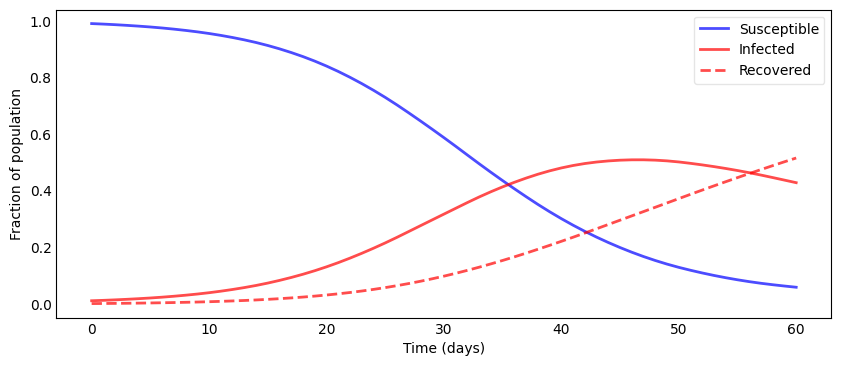

[{'beta': 0.16693877551020408, 'gamma': 0.030510204081632655, 'assignment': '0'}]


In [7]:
# Consistency Query

# USER: set num_dim_points with how many points for each parameter you'd like to evaluate

# USER: set bounds
beta_search_bounds = [0.16693877551020408, 0.16693877551020408]
gamma_search_bounds = [0.030510204081632655, 0.030510204081632655]

param_choices_true_false = ps("any", {"beta": beta_search_bounds, "gamma": gamma_search_bounds}, query_condition=query_2, rtol=1e-3, num_dim_points=1, plot=True)
print(param_choices_true_false)

id_number = randint(10**5, 10**6 - 1)

with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
    json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)


# Plot "true/false" points.  Is there any way of characterizing these regions?
# sir_model.plot_two_params("gamma", "beta", param_choices_true_false)

{'beta': 0.18367346938775508, 'gamma': 0.061224489795918366, 'assignment': '1'}


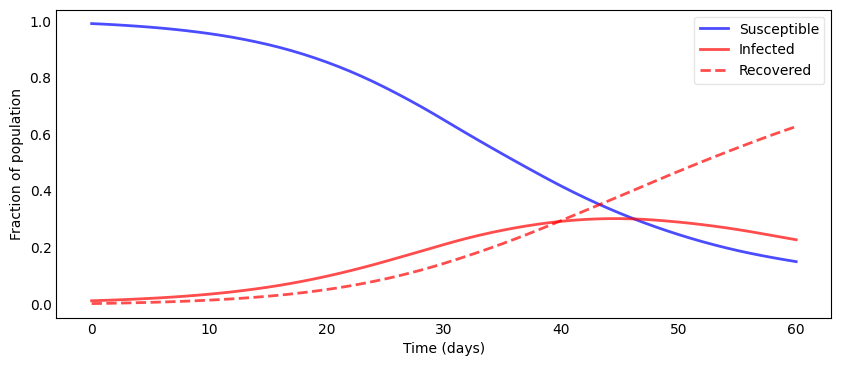

In [13]:
# Parameterization

# USER: set num_dim_points with how many points for each parameter you'd like to evaluate

# USER: set bounds
beta_search_bounds = [0.0,1.0]
gamma_search_bounds = [0.0,1.0]

num_dim_points = 50

param_choices_true_false = ps("any", {"beta": beta_search_bounds, "gamma": gamma_search_bounds}, query_condition=query_2, rtol=1e-3, num_dim_points=num_dim_points)
# print(param_choices_true_false)

id_number = randint(10**5, 10**6 - 1)

with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
    json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)


my_params = [p for p in param_choices_true_false if p['assignment']=="1"][0]
print(my_params)
param_assignment, sim = eval_point(my_params["beta"], my_params["gamma"], plot=True, mxstep=20, query_condition=query_1)


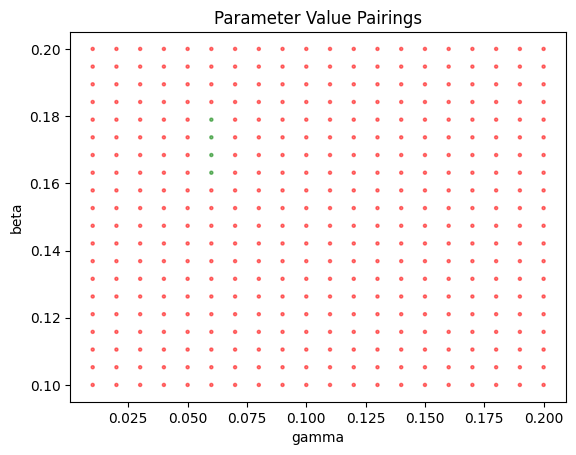

In [4]:
# Parameter Synthesis

# USER: set num_dim_points with how many points for each parameter you'd like to evaluate
num_points = 20

# USER: set bounds
beta_search_bounds = [0.1,0.2]
gamma_search_bounds = [0.01,0.2]

# beta_search_bounds = [0.13,0.16]
# gamma_search_bounds = [0.025,0.03]

param_choices_true_false = ps("all", {"beta": beta_search_bounds, "gamma": gamma_search_bounds}, query_condition=query_2, rtol=1e-3, num_dim_points=num_points)
# print(param_choices_true_false)

id_number = randint(10**5, 10**6 - 1)

with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
    json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)


# Plot "true/false" points.  Is there any way of characterizing these regions?
sir_model.plot_two_params("gamma", "beta", param_choices_true_false)


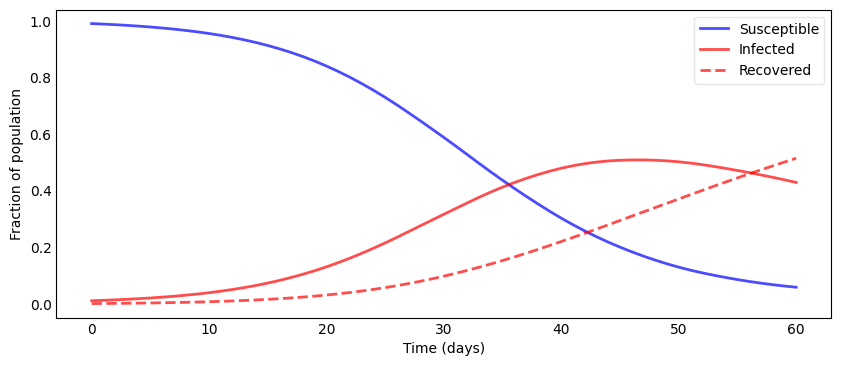

(10, 0.9549483347778465)
{'beta': 0.16693877551020408, 'gamma': 0.030510204081632655, 'assignment': '1'}


In [31]:



my_params = [p for p in param_choices_true_false if p['assignment']=="1"][-1]
param_assignment, sim = eval_point(my_params["beta"], my_params["gamma"], plot=True, mxstep=20, query_condition=query_1)
# param_assignment, sim = eval_point(0.25, 0.027755102040816326, plot=True, rtol=1e-10)
S, I, R = sim.T

print(list(enumerate(S))[10])
# print([S[i]-S[i-1] for i in range(1, len(S))])
print(my_params)
